# EEG Statistics

## Epochs
We need epochs for the statistical tests, so you can insert your preprocessed data from earlier tutorials under this section. I'll read in some epochs from your FaceWord which I prepared earlier and I'll be looking at the words/images contrast.

(Tip: You can save the epochs object you created in your preprocessing notebook by using epochs.save('your_epochs-epo.fif'))

(Extra tip: You can run terminal commands from cells using the os.system() function or simply writing an exclamation mark before the command)

## Importing modules

In [1]:
!python -m pip install mne --quiet
!pip install scikit-learn --quiet
!pip install pandas --quiet


import numpy as np
import pandas as pd
import mne

## Importing epochs

In [9]:
epochs = mne.read_epochs('ownExperiment_epochs-epo.fif')

Reading /work/studybuddies_neuroScience/own_experiment/ownExperiment_epochs-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
523 matching events found
No baseline correction applied
0 projection items activated


### Dividing into different conditions

In [23]:
incorr2_epocs = epochs['recog_phase/incorr2/second']
incorr4_epocs = epochs['recog_phase/incorr4/fourth']
corr5_epocs = epochs['recog_phase/corr/fifth']

Number of events,25
Events,recog_phase/incorr2/second/1: 4recog_phase/incorr2/second/3: 3recog_phase/incorr2/second/4: 4recog_phase/incorr2/second/6: 4recog_phase/incorr2/second/7: 4recog_phase/incorr2/second/8: 3recog_phase/incorr2/second/9: 3
Time range,-0.200 – 0.496 sec
Baseline,-0.200 – 0.000 sec


## Windowed mean
Now we have our two conditions: trials with words vs images. One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1) Segmenting our data using only certain channels in a specific time window. **Keep in mind which time window and channels should be established a priori, for instance according to the literature.** 
2) Taking the mean of that window across channels and and samples.
3) Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant, we can keep one dimension of the individual data, i.e. the trials.

### T-test
We can now do a t-test on the trials from the two conditions, to establish whether the means of the two groups are statistically significant.

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.

In [11]:
incorr2_data = incorr2_epocs.get_data(picks=['O1', 'Oz', 'O2'], tmin=.1, tmax=.2) #01,Oz,02 centered around visCortex
print(incorr2_data.shape)

incorr4_data = incorr4_epocs.get_data(picks=['O1', 'Oz', 'O2'], tmin=.1, tmax=.2)
print(incorr4_data.shape)

corr5_data = corr5_epocs.get_data(picks=['O1', 'Oz', 'O2'], tmin=.1, tmax=.2)
print(corr5_data.shape)

(25, 3, 25)
(26, 3, 25)
(31, 3, 25)


I've also tried adding 
```, 'P3', 'P4', 'Pz'``` 
to the channels (picks) which didn't improve anything

Investigating the resulting data; how many dimensions does the data have? What do you think they represent (i.e. which dimension is channels, trials, etc.)?

Now we can average over the data so we only have the trials dimension.

In [12]:
# Incorrect second
incorr2_mean = np.mean(incorr2_data, axis=2) # averaging over the third dimension of the data
incorr2_mean = np.mean(incorr2_mean, axis=1) # averaging over the second dimension of the data
print(incorr2_mean.shape)

# Incorrect fourth
incorr4_mean = np.mean(incorr4_data, axis=2)
incorr4_mean = np.mean(incorr4_mean, axis=1)
print(incorr4_mean.shape)

# Correct fifth
corr5_mean = np.mean(corr5_data, axis=2)
corr5_mean = np.mean(corr5_mean, axis=1)
print(corr5_mean.shape)

(25,)
(26,)
(31,)


In [13]:
from scipy import stats as st
import statistics as stats

st.ttest_ind(a=incorr2_mean, b=incorr4_mean)

Ttest_indResult(statistic=-1.2293498578168072, pvalue=0.22481137583631694)

# Mixed effects models

By averaging over multiple dimensions of our data, we are of couse throwing away some information. If we had multiple participants, we could add the trials back into the mix by using a mixed-effects model. Since we already have trials, we could add the samples or channels as random effects in a mixed-effects model.

We can export the data in a csv format so you have the option of doing a bit of modelling in R if you would like to ;-)

In [8]:
shape = incorr_data.shape
index = pd.MultiIndex.from_product([range(s)for s in shape])
word_pos = pd.DataFrame({'word_pos_data': word_pos_data.flatten()}, index=index).reset_index()
word_pos.to_csv('word_pos_data.csv', index=False)

shape = word_neg_data.shape
index = pd.MultiIndex.from_product([range(s)for s in shape])
word_neg = pd.DataFrame({'word_neg_data': word_neg_data.flatten()}, index=index).reset_index()
word_neg.to_csv('word_neg_data.csv', index=False)

NameError: name 'incorr_data' is not defined

# Permutation test
The null hypothesis (H0) is that the data in the two conditions comes from the same probability distribution (i.e. they are interchangeable). In order to test this we scramble the data in the conditions n amount of times to get an idea of what distributions of cluster sizes we would expect if there is no difference between conditions. Based on this distribution we can establish how large a cluster should be to cross our significance level (e.g. 0.05) and then compare this to the clusters based on our conditions. If the highest value from our clusters is larger, this suggests that the data in the conditions are not interchangeable (i.e. the difference between them is significant).

In [14]:
# getting the data from our conditions
X = [epochs[k].get_data() for k in ['recog_phase/incorr2/second', 'recog_phase/incorr4/fourth']]
print(X[0].shape)

# transposing
X = [np.transpose(x, (0, 2, 1)) for x in X]
print(X[0].shape)

(25, 30, 175)
(25, 175, 30)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


Text(0.5, 1.0, 'Between-sensor adjacency')

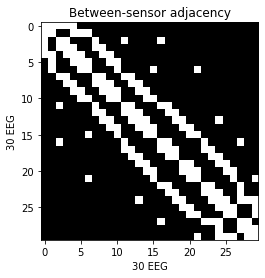

In [25]:
import matplotlib.pyplot as plt

# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [26]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 4.038393
stat_fun(H1): min=0.000000 max=19.176384
Running initial clustering
Found 37 clusters
Permuting 999 times...


</opt/conda/lib/python3.7/site-packages/decorator.py:decorator-gen-462>:12: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test



Computing cluster p-values
Done.


The code for this plot is a bit long and complex but you don't have to go through it all, just swap in your conditions in the first couple of lines :-)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
colors = {"Word": "crimson", "Image": 'steelblue'}

# organising data for plotting
evokeds = {cond: epochs[cond].average() for cond in ['recog_phase/incorr2/second', 'recog_phase/incorr4/fourth']} 

# looping over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpacking cluster information
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # getting signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # creating spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialising the figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plotting average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # creating additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # adding axes for colourbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # adding new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plotting temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean-up
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()